Note download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

## Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use their data please reference their dataset properly to give them credit for their contribution.

In [1]:
import lasio
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from operator import itemgetter

# in and our directories

In [2]:
data_locations = Path(
    "../../data/raw/geolink_dataset/GEOLINK North sea wells with Lithology interpretation/GEOLINK_Lithology and wells NORTH SEA"
)
data_locations_wellheads = Path("../../data/raw/geolink_dataset/norge_well_heads")
interim_locations = Path("../../data/processed/geolink_norge_dataset/")

# load and save as parquet

In [4]:
df_lithology = pd.read_excel(data_locations / "../Lithology code data.xlsx", header=1)[
    :-1
]
df_lithology["Abbreviation"] = pd.to_numeric(df_lithology["Abbreviation"])
df_lithology.to_parquet(
    interim_locations / "geolink_norge_lithology.parquet", compression="gzip"
)
df_lithology

,Lithology,Color,Lithology Attribute,Abbreviation
0,Aeolian Sandstone,LightYellow,CrossBedded Sand,35
1,Anhydrite,Light Magenta,Anhydrite,22
2,Argillaceous Limestone,Dodger Blue,Chalk,12
3,Arkose,LightGoldenrod,Gravel,36
4,Basement,Salmon,Intrusive,23
5,Biogenic Ooze,DarkYellow,Sandy Shale,25
6,Calcareous Cement,Cyan,Sandy Limestone,16
7,Calcareous Debris Flow,Turquoise,Breccia,31
8,Calcareous Shale,DarkCyan,Calcareous Shale,14
9,Carnallite,Magenta,Halite,33


In [327]:
df_well_tops = pd.concat(
    [
        pd.read_csv(data_locations_wellheads / "wellbore_exploration_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_development_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_other_all.csv"),
    ]
)
df_well_tops["wlbWellboreName_geolink"] = df_well_tops["wlbWellboreName"].str.replace(
    "/", "_"
)


# add dates
date_cols = ["wlbEntryDate", "wlbCompletionDate"]
for c in date_cols:
    df_well_tops[c] = pd.to_datetime(df_well_tops[c])  # .astype('str')

df_well_tops["wlbNsDecDeg"] = df_well_tops["wlbNsDecDeg"].replace(0, np.nan)
df_well_tops["wlbEwDesDeg"] = df_well_tops["wlbEwDesDeg"].replace(0, np.nan)

a = set(df_well_tops.columns)
df_well_tops = df_well_tops.dropna(axis=1, thresh=0.9 * len(df_well_tops))
b = set(df_well_tops.columns)
print("removed", a - b)

# make into geodataframe
df_well_tops = gpd.GeoDataFrame(
    df_well_tops,
    geometry=gpd.points_from_xy(df_well_tops.wlbEwDesDeg, df_well_tops.wlbNsDecDeg),
)
df_well_tops

removed {'wlbAgeWithHc3', 'wlbReentry', 'wlbFormationWithHc3', 'wlbBottomHoleTemperature', 'wlbMultilateral', 'wlbEntryPreDrillDate', 'wlbFormationWithHc1', 'wlbSiteSurvey', 'wlbProductionFacility', 'fldNpdidField', 'wlbKickOffPoint', 'wlbDiscoveryWellbore', 'wlbReclassFromWellbore', 'wlbNpdidSiteSurvey', 'dscNpdidDiscovery', 'wlbContentPlanned', 'wlbReleasedDate', 'wlbDiskosWellboreParent', 'prlNpdidProdLicenceTarget', 'wlbDrillingFacilityFixedOrMoveable', 'fclNpdidFacilityProducing', 'wlbNpdidWellboreReclass', 'wlbDiscovery', 'prlNpdidProductionLicence', 'wlbLicenceTargetName', 'wlbPluggedAbandonDate', 'wlbFactMapUrl', 'wlbDiskosWellboreType', 'wlbAgeWithHc1', 'wlbFormationWithHc2', 'wlbAgeAtTd', 'wlbField', 'wlbDrillingDays', 'wlbDateReclass', 'wlbPurposePlanned', 'wlbFormationAtTd', 'wlbSeismicLocation', 'wlbNamePart6', 'wlbPressReleaseUrl', 'wlbMaxInclation', 'wlbSubSea', 'wlbFinalVerticalDepth', 'wlbWdssQcDate', 'wlbContent', 'wlbPluggedDate', 'wlbDateUpdatedMax', 'wlbAgeWithHc2'

,wlbWellboreName,wlbWell,wlbDrillingOperator,wlbProductionLicence,wlbPurpose,wlbWellType,wlbEntryDate,wlbCompletionDate,wlbDrillPermit,wlbKellyBushElevation,...,wlbNamePart1,wlbNamePart2,wlbNamePart3,wlbNamePart4,wlbFactPageUrl,wlbNpdidWellbore,wlbDateUpdated,datesyncNPD,wlbWellboreName_geolink,geometry
0,1/2-1,1/2-1,Phillips Petroleum Norsk AS,143,WILDCAT,EXPLORATION,1989-03-20,1989-04-06,604-L,22.0,...,1,2,,1,https://factpages.npd.no/factpages/default.asp...,1382,03.10.2019,03.07.2020,1_2-1,POINT (2.47658 56.88752)
1,1/2-2,1/2-2,Paladin Resources Norge AS,143 CS,WILDCAT,EXPLORATION,2005-12-14,2006-02-02,1103-L,40.0,...,1,2,,2,https://factpages.npd.no/factpages/default.asp...,5192,03.10.2019,03.07.2020,1_2-2,POINT (2.49657 56.99222)
2,1/3-1,1/3-1,A/S Norske Shell,011,WILDCAT,EXPLORATION,1968-06-07,1968-11-11,15-L,26.0,...,1,3,,1,https://factpages.npd.no/factpages/default.asp...,154,03.10.2019,03.07.2020,1_3-1,POINT (2.85139 56.85583)
3,1/3-2,1/3-2,A/S Norske Shell,011,WILDCAT,EXPLORATION,1969-05-14,1969-07-27,26-L,26.0,...,1,3,,2,https://factpages.npd.no/factpages/default.asp...,165,03.10.2019,03.07.2020,1_3-2,POINT (2.75000 56.93611)
4,1/3-3,1/3-3,Elf Petroleum Norge AS,065,WILDCAT,EXPLORATION,1982-08-22,1983-03-24,343-L,25.0,...,1,3,,3,https://factpages.npd.no/factpages/default.asp...,87,06.03.2020,03.07.2020,1_3-3,POINT (2.98168 56.95238)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,8006/8-U-4,8006/8-U-4,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-29,1993-08-30,320-GJ,0.0,...,8006,8,U,4,https://factpages.npd.no/factpages/default.asp...,2234,03.10.2019,03.07.2020,8006_8-U-4,POINT (6.59040 80.26470)
1115,8008/7-U-1,8008/7-U-1,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GK,0.0,...,8008,7,U,1,https://factpages.npd.no/factpages/default.asp...,2235,03.10.2019,03.07.2020,8008_7-U-1,POINT (8.22730 80.47440)
1116,8008/7-U-2,8008/7-U-2,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GL,0.0,...,8008,7,U,2,https://factpages.npd.no/factpages/default.asp...,2236,03.10.2019,03.07.2020,8008_7-U-2,POINT (8.22730 80.47460)
1117,8008/7-U-3,8008/7-U-3,OCEAN DRILLING PROGRAM TEXAS A & M UNIVERSITY,NaN,SCIENTIFIC,OTHER,1993-08-22,1993-08-24,320-GM,0.0,...,8008,7,U,3,https://factpages.npd.no/factpages/default.asp...,2237,03.10.2019,03.07.2020,8008_7-U-3,POINT (8.22730 80.47480)


## Las files

We can now proceed to import these files as las files and get their dataframes and hopefully put them into a data format that is more suited for ML tasks.

In [36]:
if not (interim_locations / "geolink_norge_well_logs_raw.parquet").exists():

    # load las files
    well_dataframes = []
    files = sorted(data_locations.glob("*.las"))
    for f in tqdm(files):
        df = lasio.read(f).df()
        df["Well"] = f.stem
        well_dataframes.append(df)

    df_all = pd.concat(well_dataframes)

    df_all["Well"] = df_all["Well"].astype("category")

    # Name lithology
    litho_dict = df_lithology.set_index("Abbreviation")["Lithology"].to_dict()
    df_all["LITHOLOGY_GEOLINK"] = (
        df_all["LITHOLOGY_GEOLINK"].replace(litho_dict).astype("category")
    )

    # unique index
    df_all = df_all.reset_index()  # .set_index(['Well', 'DEPT'])

    df_all.to_parquet(
        interim_locations / "geolink_norge_well_logs_raw.parquet", compression="gzip"
    )

df_all = pd.read_parquet(interim_locations / "geolink_norge_well_logs_raw.parquet")

## Clean las files

In [329]:
# Clean.

# must have well head
df_all_clean2 = df_all[
    df_all.Well.apply(lambda s: s in set(df_well_tops["wlbWellboreName_geolink"]))
]

# must have lithology. Remove logs which are present less than half the time
df_all_clean2 = df_all_clean2.dropna(subset=["LITHOLOGY_GEOLINK"])
print("nans", df_all_clean2.isna().mean().sort_values())
df_all_clean1 = df_all_clean2.dropna(axis=1, thresh=0.9 * len(df_all_clean2))
print(f"kept {len(df_all_clean1.columns)/len(df_all_clean2.columns):%} cols")
df_all_clean = df_all_clean1.dropna(axis=0)
print(f"kept {len(df_all_clean)/len(df_all_clean2):%} rows")
df_all_clean

nans DEPT                 0.000000
Well                 0.000000
LITHOLOGY_GEOLINK    0.000000
GR                   0.010929
RDEP                 0.022874
CALI                 0.051238
DTC                  0.053623
RMED                 0.063382
RHOB                 0.068390
DRHO                 0.142166
NPHI                 0.233100
SP                   0.302008
RSHA                 0.318130
BS                   0.558160
DTE                  0.659973
PEF                  0.665123
ROP                  0.816401
DCAL                 0.831389
DTS                  0.868451
RMIC                 0.899241
URAN                 0.922309
THOR                 0.922324
MUDWEIGHT            0.956972
SGR                  0.958199
RXO                  0.965905
DT                   0.970353
RHOM                 0.980830
CGR                  0.996378
TGAS                 0.998659
dtype: float64
kept 31.034483% cols
kept 82.413526% rows


,DEPT,LITHOLOGY_GEOLINK,CALI,RHOB,GR,DTC,RDEP,RMED,Well
11302,2215.917725,Shaly Silt,14.438001,2.363000,60.285748,134.253601,0.737006,0.785088,15_9-12
11303,2216.070068,Shaly Silt,14.633000,2.340000,63.250000,129.101868,0.741000,0.840000,15_9-12
11304,2216.222412,Shaly Silt,14.813001,2.314000,61.405998,122.476944,0.752000,0.858000,15_9-12
11305,2216.375000,Shaly Silt,14.383001,2.293000,62.561596,116.908607,0.739962,0.857046,15_9-12
11306,2216.527344,Shaly Silt,14.202999,2.275000,61.691055,115.390953,0.715966,0.886082,15_9-12
...,...,...,...,...,...,...,...,...,...
3147061,4569.153320,Cross Bedded Sst,8.538000,2.643616,50.886002,63.442799,6.727000,6.835000,7_3-1
3147062,4569.305664,Cross Bedded Sst,8.540000,2.631049,51.219002,63.450794,6.639000,6.690000,7_3-1
3147063,4569.458008,Cross Bedded Sst,8.548000,2.626054,51.671001,63.590557,6.551000,6.520000,7_3-1
3147064,4569.610352,Cross Bedded Sst,8.552000,2.624065,51.820999,64.036644,6.464000,6.462185,7_3-1


In [330]:
# Split by well name
wells_val = [
    "35_11-1",
    "35_11-10",
    "35_11-11",
    "35_11-12",
    "35_11-13",
    "35_11-15 S",
    "35_11-2",
    "35_11-5",
    "35_11-6",
    "35_11-7",
    "35_12-1",
]

wells_test = [
    "34_10-12",
    "34_10-16 R",
    "34_10-17",
    "34_10-19",
    "34_10-21",
    "34_10-23",
    "34_10-33",
    "34_10-35",
    "34_10-5",
    "34_10-7",
    "34_11-1",
    "34_11-2 S",
    "34_11-3 T2",
]

In [331]:
df_all_clean_test = df_all_clean[df_all_clean.Well.apply(lambda s: s in wells_test)]
df_all_clean_train = df_all_clean[
    df_all_clean.Well.apply(lambda s: (s not in wells_test) and (s not in wells_val))
]
assert len(set(df_all_clean_val.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_val))) == 0
len(df_all_clean_train), len(df_all_clean_val), len(df_all_clean_test)

(1192269, 88321, 68662)

In [332]:
df_all_clean_train.to_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet", compression="gzip"
)
df_all_clean_test.to_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet", compression="gzip"
)
df_all_clean_val.to_parquet(
    interim_locations / "geolink_norge_well_logs_val.parquet", compression="gzip"
)

# Others

In [333]:
df_picks = pd.read_excel(
    data_locations / "../NPD stratigraphic picks north sea.xlsx", header=0
)
df_picks.to_parquet(
    interim_locations / "geolink_norge_picks.parquet", compression="gzip"
)

In [354]:
df_picks

,Unnamed: 0,Well identifier,Surface,X,Y,Z,MD,Geological age,TVT,TST,Interpreter,Observation number
0,21675,10/4-1,CROMER KNOLL GP. Top,628531.41,6394710.62,-1350.90,1382.0,4.21,NaN,NaN,NPD,1
1,21660,10/4-1,Roedby Fm. Top,628531.41,6394710.62,-1350.90,1382.0,98.90,NaN,NaN,NPD,1
2,21656,10/4-1,Sola Fm. Top,628531.47,6394710.62,-1381.90,1413.0,102.50,NaN,NaN,NPD,1
3,21664,10/4-1,Aasgard Fm. Top,628531.50,6394710.61,-1397.90,1429.0,117.00,NaN,NaN,NPD,1
4,21668,10/4-1,VESTLAND GP. Top,628531.27,6394713.59,-2242.88,2274.0,1.00,NaN,NaN,NPD,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21671,18878,9/8-1,Vaale Fm. Top,580466.31,6356474.78,-1202.50,1233.0,0.00,NaN,NaN,NPD,1
21672,18877,9/8-1,NORDLAND GP. Top,580466.31,6356474.78,-67.50,98.0,0.00,NaN,NaN,NPD,1
21673,18876,9/8-1,BOKNFJORD GP. Top,580466.31,6356474.78,-1746.50,1777.0,1.00,NaN,NaN,NPD,1
21674,18868,9/8-1,Egersund Fm. Top,580466.31,6356474.78,-1794.50,1825.0,153.80,NaN,NaN,NPD,1


## Well heads part 2

In [334]:
# only wells we use
a = sorted(df_all.Well.unique())
df_well_tops = df_well_tops[
    df_well_tops["wlbWellboreName_geolink"].apply(lambda s: s in a)
]

In [335]:
df_well_tops.to_file(interim_locations / "norge_well_tops.gpkg", driver="GPKG")

# Example Load

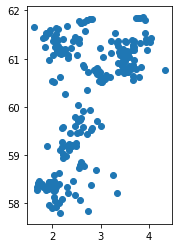

In [5]:
# Test load
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
)  # .set_index(['Well', 'DEPT'])

df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
]
df_well_tops.plot()

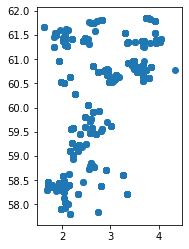

In [6]:
# Merge well tops and well logs, a selection
df_all_clean3 = pd.merge(
    left=df_all_clean2.sample(1000),
    right=df_well_tops_minimal,
    left_on="Well",
    right_on="wlbWellboreName_geolink",
    how="left",
).drop(columns="wlbWellboreName_geolink")
df_all_clean3 = df_all_clean3.set_index(['Well', 'DEPT'])
df_all_clean3 = gpd.GeoDataFrame(df_all_clean3, geometry=df_all_clean3['geometry'])
df_all_clean3.plot()
# df_all_clean3

In [7]:
df_picks = pd.read_parquet(interim_locations / "geolink_norge_picks.parquet")
df_picks

,Unnamed: 0,Well identifier,Surface,X,Y,Z,MD,Geological age,TVT,TST,Interpreter,Observation number
0,21675,10/4-1,CROMER KNOLL GP. Top,628531.41,6394710.62,-1350.90,1382.0,4.21,NaN,NaN,NPD,1
1,21660,10/4-1,Roedby Fm. Top,628531.41,6394710.62,-1350.90,1382.0,98.90,NaN,NaN,NPD,1
2,21656,10/4-1,Sola Fm. Top,628531.47,6394710.62,-1381.90,1413.0,102.50,NaN,NaN,NPD,1
3,21664,10/4-1,Aasgard Fm. Top,628531.50,6394710.61,-1397.90,1429.0,117.00,NaN,NaN,NPD,1
4,21668,10/4-1,VESTLAND GP. Top,628531.27,6394713.59,-2242.88,2274.0,1.00,NaN,NaN,NPD,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21671,18878,9/8-1,Vaale Fm. Top,580466.31,6356474.78,-1202.50,1233.0,0.00,NaN,NaN,NPD,1
21672,18877,9/8-1,NORDLAND GP. Top,580466.31,6356474.78,-67.50,98.0,0.00,NaN,NaN,NPD,1
21673,18876,9/8-1,BOKNFJORD GP. Top,580466.31,6356474.78,-1746.50,1777.0,1.00,NaN,NaN,NPD,1
21674,18868,9/8-1,Egersund Fm. Top,580466.31,6356474.78,-1794.50,1825.0,153.80,NaN,NaN,NPD,1


In [8]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean

LITHOLOGY_GEOLINK       CALI      RHOB         GR  \
Well    DEPT                                                            
15_9-12 2215.917725        Shaly Silt  14.438001  2.363000  60.285748   
        2216.070068        Shaly Silt  14.633000  2.340000  63.250000   
        2216.222412        Shaly Silt  14.813001  2.314000  61.405998   
        2216.375000        Shaly Silt  14.383001  2.293000  62.561596   
        2216.527344        Shaly Silt  14.202999  2.275000  61.691055   
...                               ...        ...       ...        ...   
7_3-1   4569.153320  Cross Bedded Sst   8.538000  2.643616  50.886002   
        4569.305664  Cross Bedded Sst   8.540000  2.631049  51.219002   
        4569.458008  Cross Bedded Sst   8.548000  2.626054  51.671001   
        4569.610352  Cross Bedded Sst   8.552000  2.624065  51.820999   
        4569.762695  Cross Bedded Sst   8.546000  2.636137  51.327999   

                            DTC      RDEP      RMED  
Well    DEPT                                         
15_9-12 2215.917725  134.253601  0.737006  0.785088  
        2216.070068  129.101868  0.741000  0.840000  
        2216.222412  122.476944  0.752000  0.858000  
        2216.375000  116.908607  0.739962  0.857046  
        2216.527344  115.390953  0.715966  0.886082  
...                         ...       ...       ...  
7_3-1   4569.153320   63.442799  6.727000  6.835000  
        4569.305664   63.450794  6.639000  6.690000  
        4569.458008   63.590557  6.551000  6.520000  
        4569.610352   64.036644  6.464000  6.462185  
        4569.762695   64.322495  6.423000  6.439074  

[1192269 rows x 7 columns]

# Plot facies

In [3]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean

LITHOLOGY_GEOLINK       CALI      RHOB         GR  \
Well    DEPT                                                            
15_9-12 2215.917725        Shaly Silt  14.438001  2.363000  60.285748   
        2216.070068        Shaly Silt  14.633000  2.340000  63.250000   
        2216.222412        Shaly Silt  14.813001  2.314000  61.405998   
        2216.375000        Shaly Silt  14.383001  2.293000  62.561596   
        2216.527344        Shaly Silt  14.202999  2.275000  61.691055   
...                               ...        ...       ...        ...   
7_3-1   4569.153320  Cross Bedded Sst   8.538000  2.643616  50.886002   
        4569.305664  Cross Bedded Sst   8.540000  2.631049  51.219002   
        4569.458008  Cross Bedded Sst   8.548000  2.626054  51.671001   
        4569.610352  Cross Bedded Sst   8.552000  2.624065  51.820999   
        4569.762695  Cross Bedded Sst   8.546000  2.636137  51.327999   

                            DTC      RDEP      RMED  
Well    DEPT                                         
15_9-12 2215.917725  134.253601  0.737006  0.785088  
        2216.070068  129.101868  0.741000  0.840000  
        2216.222412  122.476944  0.752000  0.858000  
        2216.375000  116.908607  0.739962  0.857046  
        2216.527344  115.390953  0.715966  0.886082  
...                         ...       ...       ...  
7_3-1   4569.153320   63.442799  6.727000  6.835000  
        4569.305664   63.450794  6.639000  6.690000  
        4569.458008   63.590557  6.551000  6.520000  
        4569.610352   64.036644  6.464000  6.462185  
        4569.762695   64.322495  6.423000  6.439074  

[1192269 rows x 7 columns]

In [4]:
# # Load in colors
# xtra={'lightmagenta':'#ff80ff', 'darkyellow':'#CCCC00','mediumgray':'#939799'}
# from colour import Color
# def get_color(name):
#     if not isinstance(name, str):
#         return name
    
#     try:
#         return Color(name).hex_l
#     except ValueError:
#         pass
    
#     try:
#         return Color(name.replace(' ', '')).hex_l
#     except ValueError:
#         pass
    
#     try:
#         return Color(name.replace(' ', '').lower()).hex_l
#     except ValueError:
#         pass
    
#     try:
#         return Color(name.lower()).hex_l
#     except ValueError:
#         pass
    
#     name_l = name.replace(' ', '').lower()
#     return xtra[name_l]
#     # name_to_hex

# df_lithology = pd.read_excel(data_locations / "../Lithology code data.xlsx", header=1)
# print(df_lithology)
# raw_color_dict = df_lithology[['Lithology', 'Color']].set_index('Lithology')['Color'].to_dict()
# color_dict = {n:get_color(c) for n,c in raw_color_dict.items()}
# color_dict

In [5]:
abbrv = {'Argillaceous Limestone': 'Arg_Ls',
 'Calcareous Cement': 'Calc_Cmt',
 'Cinerite': 'Cinerite',
 'Coal': 'Coal',
 'Cross Bedded Sst': 'x-bd_Sst',
 'Limestone': 'Ls',
 'Marlstone': 'Mrl',
 'Sandstone': 'SSt',
 'Sandy Silt': 'Snd_Slt',
 'Shaly Silt': 'Shl_Slt',
 'Silt': 'Slt',
 'Silty Sand': 'Slt_Snd',
 'Silty Shale': 'Slt_Shl'}

In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

color_dict = {'Aeolian Sandstone': '#ffffe0',
 'Anhydrite': '#ff80ff',
 'Argillaceous Limestone': '#1e90ff',
 'Arkose': '#eedd82',
 'Basement': '#fa8072',
 'Biogenic Ooze': '#CCCC00',
 'Calcareous Cement': '#00ffff',
 'Calcareous Debris Flow': '#40e0d0',
 'Calcareous Shale': '#008b8b',
 'Carnallite': '#ff00ff',
 'Chalk': '#6a5acd',
 'Cinerite': '#00ffff',
 'Coal': '#000000',
 'Conglomerate': '#ffffe0',
 'Cross Bedded Sst': '#ffd700',
 'Dolomite': '#00ffff',
 'Gap': '#ffffff',
 'Halite': '#ffc0cb',
 'Kaïnite': '#fff0f5',
 'Limestone': '#6a5acd',
 'Marlstone': '#00bfff',
 'Metamorphic Rock': '#008b8b',
 'Plutonic Rock': '#ff0000',
 'Polyhalite': '#ffb6c1',
 'Porous Limestone': '#6a5acd',
 'Sandstone': '#ffff00',
 'Sandy Silt': '#d2b48c',
 'Shale': '#008b8b',
 'Shaly Silt': '#CCCC00',
 'Silt': '#ffa07a',
 'Silty Sand': '#ffffe0',
 'Silty Shale': '#006400',
 'Spiculite': '#939799',
 'Sylvinite': '#ff80ff',
 'Volcanic Rock': '#ffa500',
 'Volcanic Tuff': '#ff6347',
}

def plot_facies(facies, ax=None, colorbar=True, xlabel='Facies'):
    facies_colors = [color_dict.get(f, 'orange') for f in facies.categories]
    
    # Plot facies as image
    cluster=np.repeat(np.expand_dims(facies.codes,1), 100, 1)
    
    # custom qualitative colormap
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    # the 0.5 is to center the labels
    im=ax.imshow(cluster, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin=-0.5,vmax=len(facies.categories)-0.5)
    ax.set_xlabel(xlabel)

    divider = make_axes_locatable(ax)
    if colorbar:
        cax = divider.append_axes("right", size="20%", pad=0.05)

        # modified from https://gist.github.com/jakevdp/8a992f606899ac24b711
        # This function formatter will replace integers with target names
        formatter = plt.FuncFormatter(lambda val, loc: facies.categories[val])

        # We must be sure to specify the ticks matching our target names
        plt.colorbar(im, ticks=range(len(facies.categories)), format=formatter, cax=cax);


def plot_well(well_name, logs, facies):
    

    ztop=logs.DEPT.min(); zbot=logs.DEPT.max()


    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 12))

    ax[0].plot(logs.GR, logs.DEPT, '-g')
    ax[0].set_xlabel("GR")

    ax[1].plot(logs.CALI, logs.DEPT, '-')
    ax[1].set_xlabel("CALI")

    ax[2].plot(logs.RDEP, logs.DEPT, '-r', alpha=0.7)
    ax[2].plot(logs.RMED, logs.DEPT, '-g', alpha=0.7)
    ax[2].set_xlim(logs.RDEP.min(),100)
    ax[2].set_xlabel("RDEP (r) & RMED (g)")

    ax[3].plot(logs.RHOB, logs.DEPT, '-')
    ax[3].set_xlabel("RHOB")

    plot_facies(facies, ax[-1])
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); 
    ax[-1].set_xticklabels([])
    f.suptitle('Well: %s'%well_name, fontsize=14,y=0.94)
    

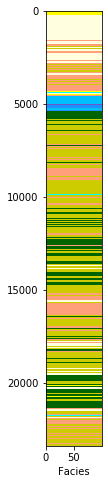

In [51]:
plt.figure(figsize=(1,8))
plot_facies(facies, plt.gca(), colorbar=False)

Index(['Argillaceous Limestone', 'Calcareous Cement', 'Marlstone',
       'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale'],
      dtype='object')

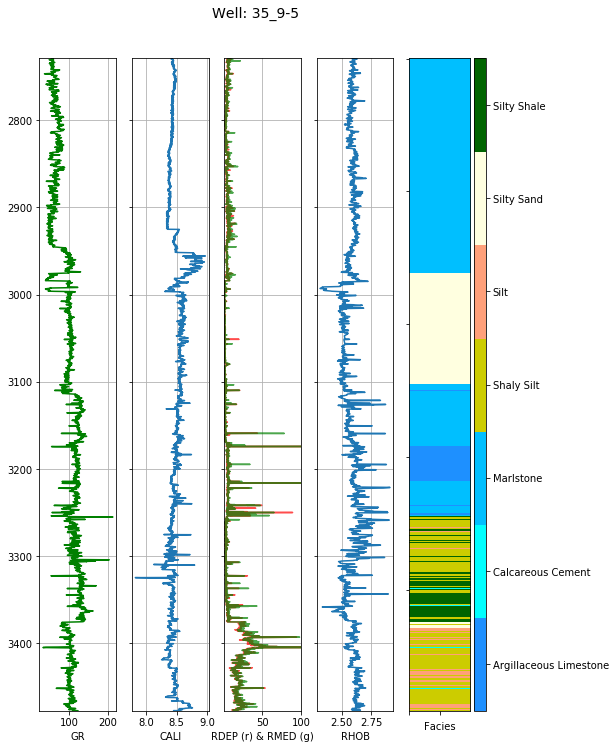

In [43]:
well_name = '35_9-5'
logs=df_all_clean.loc[well_name].reset_index().sort_values(by='DEPT')
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, logs, facies)

facies.categories

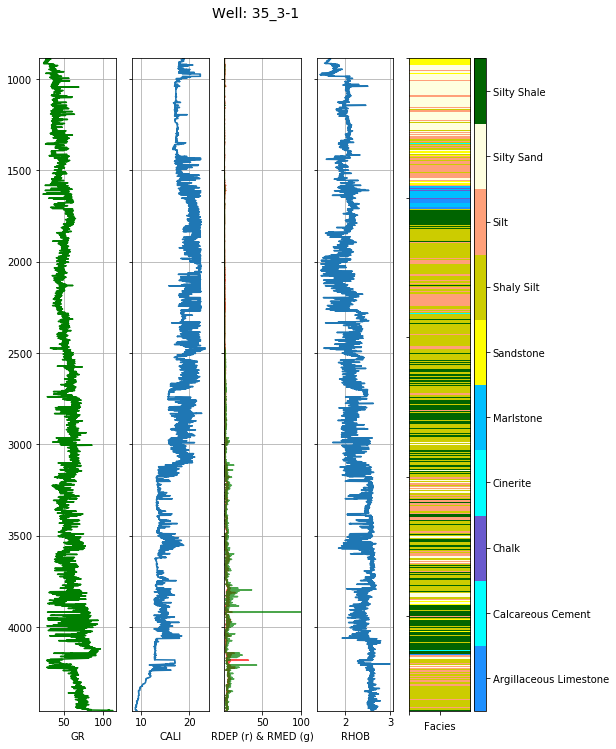

In [44]:
well_name = '35_3-1'
logs=df_all_clean.loc[well_name].reset_index().sort_values(by='DEPT')
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, logs, facies)